This project refers to ideas and codes of follwing websites:

http://krasserm.github.io/2018/04/07/latent-space-optimization/

https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb

https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder/data

###1. Data preparation
*A. Load Data*

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


In [2]:
# MNIST training and test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

x_train.shape,x_test.shape,y_train.shape,y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

In [3]:
# Seperate datasets for k=0,1,2...,9 and 0~9-k
k = 4

# Set up date for the Vk where digit = k
x_train_k = x_train[y_train==k]
x_test_k = x_test[y_test==k]
y_train_k = y_train[y_train==k]
y_test_k = y_test[y_test==k]
print(x_train_k.shape,x_test_k.shape,y_train_k.shape,y_test_k.shape)

# Set up date for the Vk' where digit = k
x_train_ks = x_train[y_train!=k]
x_test_ks = x_test[y_test!=k]
y_train_ks = y_train[y_train!=k]
y_test_ks = y_test[y_test!=k]
print(x_train_ks.shape,x_test_ks.shape)

(5842, 28, 28, 1) (982, 28, 28, 1) (5842,) (982,)
(54158, 28, 28, 1) (9018, 28, 28, 1)


In [4]:
# Hold out 10% images out of training dataset as a validation sample

#For V0~9
valid_cut = int(0.1 * y_train.shape[0])
x_valid = x_train[:valid_cut]
x_train = x_train[valid_cut:]
y_valid = y_train[:valid_cut]
y_train = y_train[valid_cut:]
print(x_train.shape,x_valid.shape,x_test.shape)

# For Vk
valid_cut_k = int(0.1 * y_train_k.shape[0])
x_valid_k = x_train_ks[:valid_cut_k]
x_train_k = x_train_k[valid_cut_k:]
y_valid_k = y_train_k[:valid_cut_k]
y_train_k = y_train_k[valid_cut_k:]
print(x_train_k.shape,x_valid_k.shape,x_test_k.shape)

# For Vk'
valid_cut_ks = int(0.1 * y_train_ks.shape[0])
x_valid_ks = x_train_ks[:valid_cut_ks]
x_train_ks = x_train_ks[valid_cut_k:]
y_valid_ks = y_train_ks[:valid_cut_ks]
y_train_ks = y_train_ks[valid_cut_ks:]
print(x_train_ks.shape,x_valid_ks.shape,x_test_ks.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)
(5258, 28, 28, 1) (584, 28, 28, 1) (982, 28, 28, 1)
(53574, 28, 28, 1) (5415, 28, 28, 1) (9018, 28, 28, 1)


###2. Model construction 

In [5]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [6]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [0]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [8]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

In [10]:
# Train V0 with MNIST images
vae.fit(x=x_train_k, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(x_valid_k, None))




Train on 5258 samples, validate on 584 samples
Epoch 1/7





5258/5258 [==============================] - 15s 3ms/step - loss: 0.2220 - val_loss: 0.3139
Epoch 2/7
5258/5258 [==============================] - 6s 1ms/step - loss: 0.1750 - val_loss: 0.3273
Epoch 3/7
5258/5258 [==============================] - 6s 1ms/step - loss: 0.1678 - val_loss: 0.3250
Epoch 4/7
5258/5258 [==============================] - 6s 1ms/step - loss: 0.1652 - val_loss: 0.3355
Epoch 5/7
5258/5258 [==============================] - 6s 1ms/step - loss: 0.1636 - val_loss: 0.3396
Epoch 6/7
5258/5258 [==============================] - 6s 1ms/step - loss: 0.1626 - val_loss: 0.3193
Epoch 7/7
5258/5258 [==============================] - 6s 1ms/step - loss: 0.1619 - val_loss: 0.3095


### 2.2.2 Add noise

In [11]:
test10 = x_test_k[0:10]
encoder = Model(input_img, z_log_sigma)
print(encoder.predict(test10)) # z_log_sigma vector

[[-3.2834277 -3.4750507]
 [-3.4486365 -3.2029605]
 [-3.3760667 -3.3942232]
 [-3.1156726 -3.195629 ]
 [-3.3626847 -3.4714518]
 [-3.9182277 -2.6405246]
 [-3.451291  -3.3665195]
 [-3.363793  -3.4225605]
 [-3.3134332 -3.2843251]
 [-3.292264  -3.4586782]]


In [12]:
test10 = x_test_k[0:10]
encoder = Model(input_img, z_mu)
encoded = encoder.predict(test10)
output10=decoder.predict(encoded,batch_size=batch_size)
print(encoded)

[[ 0.25380832  0.74739397]
 [-0.39031416  0.37584966]
 [ 0.13927534 -0.22732209]
 [ 0.7393315  -0.38427895]
 [ 0.166549    0.43889484]
 [ 0.4417672   3.2753115 ]
 [-0.02728448 -0.25930458]
 [ 0.09786046  0.38273796]
 [ 0.88729036  0.84835947]
 [ 0.1377877   1.177026  ]]


In [0]:
## Define Similarity

# import the necessary packages
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2

def mse(imageA, imageB):
  # the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  err /= float(imageA.shape[0] * imageA.shape[1])
  # return the MSE, the lower the error, the more "similar"
  # the two images are
  return err
 
def compare_images(imageA, imageB):
	# compute the mean squared error and structural similarity
	# index for the images
  m = mse(imageA, imageB)
  s = measure.compare_ssim(imageA, imageB)
  return m,s

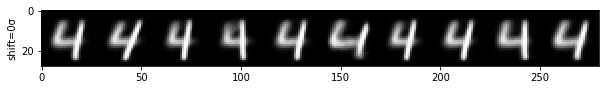

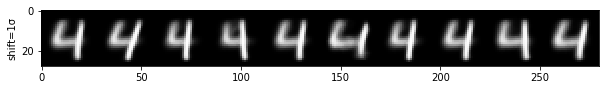

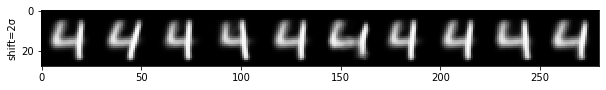

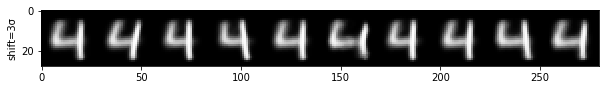

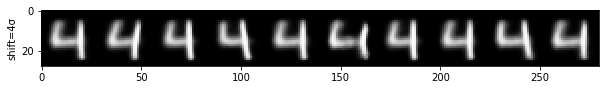

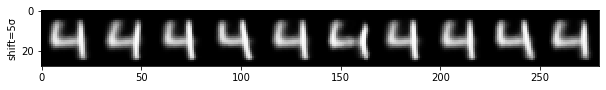

[3.685147425309359e-15, 0.004776750451949379, 0.013630398069371014, 0.021454218398452175, 0.02795822794086955, 0.03360909277649812]
[0.9999999999998954, 0.930708860006878, 0.815384295443797, 0.7114120415574716, 0.6240701325426452, 0.5519823956279526]


In [14]:
noise = 0.25
n = 10  # figure with 10x10 digits
digit_size = 28
figure = np.zeros((digit_size * 1, digit_size * n))
avg_mse_list=[]
avg_ssim_list=[]

for i in range(6):
  encoded_noise = encoded + noise * i
  output10_noise = decoder.predict(encoded_noise,batch_size=batch_size)

  # plot image
  for j in range(n):
    digit = output10_noise[j].reshape(digit_size, digit_size)
    figure[0 * digit_size: (0 + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(10, 10))
  plt.ylabel('shift=%dσ'%i)
  plt.imshow(figure, cmap='Greys_r')
  plt.show()

  # compute similarity
  mse_list=[]
  ssim_list=[]
  for x in range(10):
    m,s = compare_images(output10[x][:,:,0],output10_noise[x][:,:,0])
    mse_list.append(m)
    ssim_list.append(s)
  avg_mse=np.mean(mse_list)
  avg_ssim=np.mean(ssim_list)
  avg_mse_list.append(avg_mse)
  avg_ssim_list.append(avg_ssim)

print(avg_mse_list)
print(avg_ssim_list)

### normal distribution

In [0]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
mean_vector = encoder.predict(x_train_k, batch_size=batch_size)

encoder = Model(input_img, z_log_sigma)
log_sigma_vector = encoder.predict(x_train_k, batch_size=batch_size)

In [0]:
import pandas as pd
mean1,mean2=pd.DataFrame(mean_vector).mean(axis=0)
sigma1,sigma2=(pd.DataFrame(np.exp(log_sigma_vector)).mean(axis=0))**2

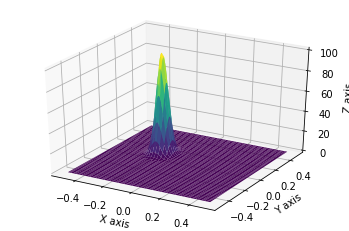

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Parameters to set
mu_x = mean1
variance_x = sigma1

mu_y = mean2
variance_y = sigma2

#Create grid and multivariate normal
x = np.linspace(-0.5,0.5,500)
y = np.linspace(-0.5,0.5,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()